# 线性回归的从零开始实现
:label:`sec_linear_scratch`

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归了。
在这一节中，(**我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器**)。
虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保我们真正知道自己在做什么。
同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。
在这一节中，我们将只使用张量和自动求导。
在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。


In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集

为了简单起见，我们将[**根据带有噪声的线性模型构造一个人造数据集。**]
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。


In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    # 函数生成一个服从均值为0，标准差为1的正态分布的张量X。该张量的形状为(num_examples, len(w))，
    X = torch.normal(0, 1, (num_examples, len(w)))
    # 这行代码通过使用torch.matmul()函数将X和w进行矩阵乘法操作，然后加上偏置项b，得到输出张量y。
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
# torch.tensor 接受一个Python列表作为输入，并返回一个对应的张量。
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
true_w.shape,features.shape,labels.shape

(torch.Size([2]), torch.Size([1000, 2]), torch.Size([1000, 1]))

注意，[**`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）**]。


In [5]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 2.1866, -0.2208]) 
label: tensor([9.3144])


通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。


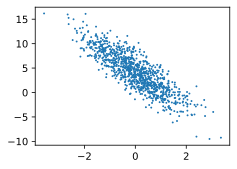

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

## 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，
该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。


In [7]:
#    yield 函数成为一个生成器函数，它会返回一个生成器对象。
#     每次调用生成器的 yield 语句时，它会生成一个值，并暂停函数的执行。
#      然后，在下一次迭代时，函数会从停止的地方继续执行，并生成下一个值。

def count_up_to(n):
    i = 0
    while i <= n:
        yield i
        i += 1

# 使用生成器函数创建生成器对象
generator = count_up_to(5)

# 迭代生成器对象并打印每个生成的值
for num in generator:
    print(num)

0
1
2
3
4
5


In [8]:
# 将样本索引列表随机打乱，以实现随机读取样本。
indices = [1, 2, 3, 4, 5]
random.shuffle(indices)
print("Shuffled indices:", indices)


Shuffled indices: [4, 3, 1, 2, 5]


In [9]:
# range(0, num_examples, batch_size) 是一个生成器，
# 用于生成从 0 到 num_examples 的整数序列，步长为 batch_size。
num_examples = 10
batch_size = 3
for i in range(0, num_examples, batch_size):
    print(i)


0
3
6
9


In [10]:
""" 虽然函数 data_iter(batch_size, features, labels) 没有显式的返回语句，但它实际上返回了一个生成器对象，
        该对象可以用于迭代操作，如 for 循环中的 for X, y in data_iter(batch_size, features, labels):。
        每次迭代时，生成器会生成下一个批次的数据，并将其赋值给 X 和 y 变量。
"""
def data_iter(batch_size, features, labels):
    # 获取数据集中样本的总数
    num_examples = len(features)
    # 创建一个包含所有样本索引的列表
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    """ range(0, num_examples, batch_size) 是一个生成器，
        用于生成从 0 到 num_examples 的整数序列，步长为 batch_size。
    """
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]) 
        """ 使用 yield 语句将每个批次的数据返回为一个元组 (features[batch_indices], labels[batch_indices])
        """
        yield features[batch_indices], labels[batch_indices]
        


通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。
每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。
GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。
每个批量的特征维度显示批量大小和输入特征数。
同样的，批量的标签形状与`batch_size`相等。


In [11]:
batch_size = 10
"""for X, y in ... 这个语法时，我们假设迭代的对象是一个可迭代对象（例如列表、元组、生成器等），
    其中每个元素都是一个包含两个元素的可迭代对象。
    在每次迭代时，将可迭代对象的第一个元素赋值给变量 X，第二个元素赋值给变量 y。
    
    data = [(1, 'a'), (2, 'b')]
    for num, letter in data:
        print("Number:", num)
        print("Letter:", letter)
        print()
        
    打印输出
    Number: 1
    Letter: a

    Number: 2
    Letter: b
""" 
for X, y in data_iter(batch_size, features, labels):
    print("X:",X, '\n',"y:", y)
    break

X: tensor([[ 1.0258,  0.8498],
        [ 0.6852,  0.5060],
        [-2.2874,  0.3175],
        [ 0.2617,  0.3945],
        [ 1.0023,  2.0421],
        [ 0.4096, -0.6550],
        [ 1.4538, -0.1376],
        [ 0.3935,  1.1881],
        [-1.3305,  0.0946],
        [ 0.0173,  1.4274]]) 
 y: tensor([[ 3.3573],
        [ 3.8490],
        [-1.4417],
        [ 3.3907],
        [-0.7313],
        [ 7.2431],
        [ 7.6014],
        [ 0.9472],
        [ 1.2243],
        [-0.6250]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。
上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。
例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。
在深度学习框架中实现的内置迭代器效率要高得多，
它可以处理存储在文件中的数据和数据流提供的数据。

## 初始化模型参数

[**在我们开始用小批量随机梯度下降优化我们的模型参数之前**]，
(**我们需要先有一些参数**)。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。


In [12]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。
每次更新都需要计算损失函数关于模型参数的梯度。
有了这个梯度，我们就可以向减小损失的方向更新每个参数。
因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。
我们使用 :numref:`sec_autograd`中引入的自动微分来计算梯度。

## 定义模型

接下来，我们必须[**定义模型，将模型的输入和参数同模型的输出关联起来。**]
回想一下，要计算线性模型的输出，
我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。
注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。
回想一下 :numref:`subsec_broadcasting`中描述的广播机制：
当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。


In [13]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## [**定义损失函数**]

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。
这里我们使用 :numref:`sec_linear_regression`中描述的平方损失函数。
在实现中，我们需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同。


In [14]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## (**定义优化算法**)

正如我们在 :numref:`sec_linear_regression`中讨论的，线性回归有解析解。
尽管线性回归有解析解，但本书中的其他模型却没有。
这里我们介绍小批量随机梯度下降。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
接下来，朝着减少损失的方向更新我们的参数。
下面的函数实现小批量随机梯度下降更新。
该函数接受模型参数集合、学习速率和批量大小作为输入。每
一步更新的大小由学习速率`lr`决定。
因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（`batch_size`）
来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。


In [15]:
import torch

x = torch.tensor([2.0], requires_grad=True)
y = x ** 2

z = y * 3

# 自动求导
gradient = torch.autograd.grad(y + z, x)
print(gradient)  # (tensor([10.]),)


(tensor([16.]),)


In [16]:
import torch

x = torch.tensor([2.0], requires_grad=True)
y = x ** 2

with torch.no_grad():
    z = y * 3
    
# 自动求导
gradient = torch.autograd.grad(y + z, x)
print(gradient)  # (tensor([10.]),)

(tensor([4.]),)


In [17]:
# params（参数），lr（学习率）和batch_size（批次大小）。
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    # with torch.no_grad() 这是一个上下文管理器，用于关闭梯度计算，以确保在参数更新阶段不会记录梯度信息。
    with torch.no_grad():
        # 这是一个迭代循环，遍历所有的参数。
        for param in params:
            # 参数更新的步骤，通过减去学习率乘以参数的梯度除以批次大小来更新参数的值。这是标准的梯度下降更新规则。
            param -= lr * param.grad / batch_size
            # 将参数的梯度置零的步骤，以便在下一次迭代中计算新的梯度。
            param.grad.zero_()

## 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的[**训练过程**]部分了。
理解这段代码至关重要，因为从事深度学习后，
相同的训练过程几乎一遍又一遍地出现。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。
最后，我们调用优化算法`sgd`来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。
我们现在忽略这些细节，以后会在 :numref:`chap_optimization`中详细介绍。


In [18]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [19]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.036293
epoch 2, loss 0.000123
epoch 3, loss 0.000045


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。
因此，我们可以通过[**比较真实参数和通过训练学到的参数来评估训练的成功程度**]。
事实上，真实参数和通过训练学到的参数确实非常接近。


In [20]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 3.8266e-05, -5.8532e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
    
    将权重初始化为零会导致问题，称为"权重对称性"问题。当所有权重初始化为相同的值时，神经网络中的每个神经元将计算相同的梯度，并且在反向传播过程中权重的更新也是相同的。这导致神经网络无法学习不同的特征和模式，限制了其表达能力和学习能力。

    此外，当权重初始化为零时，每个隐藏单元的更新规则也会相同，这会导致它们保持相同的值，并且在训练过程中无法发展出多样化的表示能力。这将限制神经网络的表达能力，使其无法有效地学习复杂的模式和特征。

    因此，将权重初始化为零是不推荐的做法。常用的权重初始化方法包括随机初始化（如从均匀分布或正态分布中随机采样）、Xavier初始化和He初始化等，这些方法有助于打破权重对称性，并为神经网络提供更好的学习能力。
    
2. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?

    是的，自动微分可以用来学习模型的参数。在建立电压和电流关系的模型时，可以定义一个损失函数，用于衡量模型预测的电流值与实际观测值之间的差异。然后，使用自动微分技术计算损失函数对模型参数（例如权重和偏置）的梯度。

    通过梯度下降等优化算法，可以使用计算得到的梯度信息来更新模型的参数，使其逐步优化并逼近真实的电压和电流关系。自动微分可以自动地计算损失函数对参数的梯度，无需手动推导或编写梯度更新的代码，大大简化了模型训练的过程。

    在使用PyTorch等深度学习框架时，自动微分是内置的，并且可以直接应用于模型的训练过程中。通过反向传播算法，框架会自动计算损失函数对模型参数的梯度，并提供相应的优化算法来更新参数。这使得模型训练更加高效和方便。

3. 能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？
    
    是的，基于普朗克定律可以使用光谱能量密度来确定物体的温度。普朗克定律描述了黑体辐射的能谱密度，即黑体在不同波长或频率上的辐射能量分布。

    根据普朗克定律，黑体辐射的能谱密度与其温度有关。具体而言，根据斯蒂芬-玻尔兹曼定律，黑体辐射的总辐射功率与温度的第四次方成正比。

    因此，通过测量物体的光谱能量密度，并结合普朗克定律和斯蒂芬-玻尔兹曼定律，可以推断出物体的温度。这种方法在天文学、热学和光学等领域中被广泛应用，例如通过测量星体的光谱能量密度来推断它们的表面温度。

    需要注意的是，确定物体的温度需要准确的测量和分析光谱能量密度数据，并结合适当的物理模型和假设。此外，还需要考虑辐射传输过程中的各种因素，如吸收、散射和传输损失等。因此，在实际应用中，需要进行详细的数据处理和模型建立，以获得准确的温度估计结果。

4. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？

    在计算二阶导数时可能会遇到以下问题：

    数值不稳定性：计算二阶导数可能导致数值不稳定性，特别是当函数具有陡峭的曲率或存在数值舍入误差时。
    计算代价高：计算二阶导数通常比计算一阶导数更加昂贵，因为它需要更多的计算量和内存消耗。
    高维度困难：在高维度问题中，计算二阶导数的计算复杂度会大大增加，因为需要计算的元素数量呈二次增长。
    解决这些问题的方法包括：

    符号计算：对于某些简单的函数，可以使用符号计算方法来计算二阶导数，以获得精确的结果。符号计算库如SymPy可以用于进行符号导数计算。
    数值稳定性技巧：为了处理数值不稳定性，可以使用数值稳定性技巧，例如增加计算精度、避免数值溢出或下溢等。此外，使用数值库中提供的优化算法和数值方法也可以改善数值计算的稳定性。
    自动微分工具：使用自动微分工具可以方便地计算高阶导数，而无需手动推导和实现。自动微分工具可以根据给定的函数表达式自动计算导数，包括一阶导数、二阶导数甚至高阶导数。流行的自动微分库如PyTorch和TensorFlow提供了方便的接口和功能来进行高阶导数的计算。
    数值逼近方法：如果无法直接计算二阶导数，可以使用数值逼近方法来近似计算。例如，可以使用数值差分方法或数值积分方法来估计二阶导数的值。这种方法虽然可能不够精确，但在某些情况下是可行的。
    需要根据具体问题的性质和要求选择合适的方法来计算二阶导数，并在计算过程中注意数值稳定性和计算效率。

5. 为什么在`squared_loss`函数中需要使用`reshape`函数？

    在 squared_loss 函数中使用 reshape 函数的目的是确保输入的 y_hat 和 y 张量具有相同的形状，以便进行元素级别的运算。

    squared_loss 函数计算的是预测值 y_hat 和真实值 y 的平方损失，公式为：

    scss
    Copy code
    loss = (1/2) * (y_hat - y)^2
    要进行元素级别的平方差运算，y_hat 和 y 的形状必须相同。但是，在实际应用中，y_hat 和 y 的形状可能不总是一致的，特别是当它们是批量数据的预测结果时。

    使用 reshape 函数可以调整 y_hat 和 y 的形状，使它们具有相同的形状。通过对其中一个张量进行形状调整，使其与另一个张量的形状相匹配，可以确保它们在进行元素级别的运算时具有相同的维度和大小。

    具体而言，reshape 函数可以将 y_hat 和 y 张量的形状调整为相同的形状，如 (batch_size, 1)，以便进行元素级别的平方差运算。

    使用 reshape 函数可以确保输入的张量形状一致，避免了尺寸不匹配的错误，并且可以保证计算结果按预期进行。

6. 尝试使用不同的学习率，观察损失函数值下降的快慢。

    当使用不同的学习率时，损失函数值的下降速度可能会有所变化。较大的学习率可能导致损失函数值迅速下降，但也可能导致跳过最优解或发散。较小的学习率可能导致收敛速度较慢，但更稳定。

    为了观察不同学习率下损失函数值的下降情况，你可以尝试以下步骤：

    初始化模型的参数（例如，权重和偏置）。
    选择不同的学习率值（例如，0.1、0.01、0.001等）。
    使用选定的学习率训练模型，迭代多个周期（epochs）。
    在每个周期中计算损失函数值，并记录下来。
    绘制损失函数值随训练周期的变化曲线，对比不同学习率下的下降速度。
    通过观察损失函数值随训练周期的变化，你可以比较不同学习率下的下降速度和收敛性能。根据观察结果，可以选择合适的学习率来优化模型。通常情况下，合适的学习率是指能够在合理的时间内收敛到较低的损失值而不发散的学习率。

    需要注意的是，选择学习率并不是一项简单的任务，它可能需要通过试验和调整来确定最佳值。不同的问题和数据集可能需要不同的学习率设置。一般建议从较小的学习率开始，逐渐增加或减小学习率，以找到最佳的学习率值。
    
7. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？
   
   如果样本个数不能被批量大小整除，data_iter函数的行为会有所变化。通常情况下，data_iter函数会按照批量大小从数据集中连续地取出样本，直到取完所有样本为止。如果样本个数不能被批量大小整除，最后一个批次可能会小于批量大小。

    具体来说，当样本个数不能被批量大小整除时，data_iter函数会在最后一个批次中返回剩余的样本。这意味着最后一个批次的大小会小于等于批量大小。这种情况下，需要注意处理最后一个批次时的边界情况，以免出现索引错误或其他错误。


In [22]:
# 以下是一个示例代码，展示了data_iter函数在样本个数不能被批量大小整除时的行为：
import torch


def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


# 假设样本个数为9，批量大小为4
features = torch.arange(9)
labels = torch.arange(9)
batch_size = 4

for X, y in data_iter(batch_size, features, labels):
    print("Batch X:", X)
    print("Batch y:", y)
    print("Batch size:", len(X))
    print()

# 可以看到，在样本个数不能被批量大小整除时，最后一个批次的大小为1。
# 这是因为在这个例子中，总共有9个样本，无法完整地组成两个大小为4的批次。


Batch X: tensor([6, 4, 3, 8])
Batch y: tensor([6, 4, 3, 8])
Batch size: 4

Batch X: tensor([2, 7, 1, 5])
Batch y: tensor([2, 7, 1, 5])
Batch size: 4

Batch X: tensor([0])
Batch y: tensor([0])
Batch size: 1



[Discussions](https://discuss.d2l.ai/t/1778)
